In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [3]:
!pip install pandas
!pip install transformers
!pip install rouge-score
!pip install transformers
!pip install accelerate
!pip install datasets

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=ebabbe901b58b9769a52f06b09fc83a872bb1181dceba5dbaa8a81b8ab96ded1
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [4]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, DataCollatorForSeq2Seq 
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from rouge_score import rouge_scorer


2024-04-22 01:04:26.216803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 01:04:26.216905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 01:04:26.346433: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Load the Amazon Fine Food Reviews dataset
df = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv')
df.shape
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def preprocess_text(text):
    """
    Preprocess the input text for the review summarization task.
    
    Args:
        text (str): The input text to be preprocessed.
        
    Returns:
        str: The preprocessed text.
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    # Join the preprocessed tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

In [7]:
def preprocess(batch):
    batch['text'] = batch['Text']
    batch['summary'] = batch['Summary']
    batch['text'] = batch['text'].apply(preprocess_text)
    batch['summary'] = batch['summary'].apply(preprocess_text)
    return batch

In [8]:
# Drop all columns except 'Summary' and 'Text' in place
df.drop(df.columns.difference(['Summary', 'Text']), axis=1, inplace=True)


In [9]:
# 3. Divide the dataset into training and testing (75:25)
train_size = int(0.75 * len(df))
test_size = len(df) - train_size
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]


In [10]:
# Filter out rows with missing values to avoid errors in processing
train_df.dropna(subset=['Text'], inplace=True)

# Calculate the word count for the 'Text' column
train_df['Text_len'] = train_df['Text'].apply(lambda x: len(str(x).split()))

# Filter the DataFrame to exclude rows where 'Text_len' is greater than 512
train_df = train_df[train_df['Text_len'] < 512]

# Optionally, you can drop the 'Text_len' column if you don't need it anymore
train_df.drop(columns=['Text_len'], inplace=True)

# Display the shape or first few rows of the modified DataFrame
print("Filtered DataFrame shape:", train_df.shape)
print(train_df.head())

/tmp/ipykernel_34/3338449.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.dropna(subset=['Text'], inplace=True)


Filtered DataFrame shape: (424639, 2)
                 Summary                                               Text
0  Good Quality Dog Food  I have bought several of the Vitality canned d...
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...
2  "Delight" says it all  This is a confection that has been around a fe...
3         Cough Medicine  If you are looking for the secret ingredient i...
4            Great taffy  Great taffy at a great price.  There was a wid...


/tmp/ipykernel_34/3338449.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Text_len'] = train_df['Text'].apply(lambda x: len(str(x).split()))


array([[<Axes: title={'center': 'Text Length'}>,
        <Axes: title={'center': 'Summary Length'}>]], dtype=object)

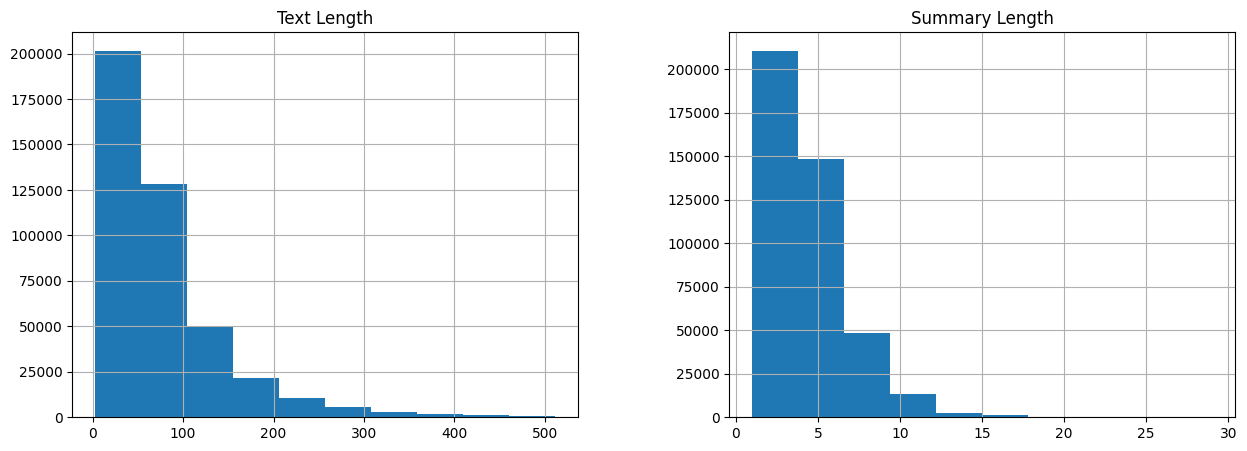

In [11]:
# Calculate the lengths of the 'Text' and 'Summary' columns
Text_len = [len(str(x).split()) for x in train_df['Text']]
Summary_len = [len(str(x).split()) for x in train_df['Summary']]

data = pd.DataFrame([Text_len, Summary_len]).T
data.columns = ['Text Length', 'Summary Length']
data.hist(figsize=(15,5))


In [12]:
# Filter out rows with missing values to avoid errors in processing
test_df.dropna(subset=['Text'], inplace=True)

# Calculate the word count for the 'Text' column
test_df['Text_len'] = test_df['Text'].apply(lambda x: len(str(x).split()))

# Filter the DataFrame to exclude rows where 'Text_len' is greater than 512
test_df = test_df[test_df['Text_len'] < 512]

# Optionally, you can drop the 'Text_len' column if you don't need it anymore
test_df.drop(columns=['Text_len'], inplace=True)

# Display the shape or first few rows of the modified DataFrame
print("Filtered DataFrame shape:", test_df.shape)
print(test_df.head())

/tmp/ipykernel_34/641869112.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.dropna(subset=['Text'], inplace=True)


Filtered DataFrame shape: (141545, 2)
                    Summary                                               Text
426340            Good Food  Science Diet has always been known for decent ...
426341                Meow!  What can I say...this is the only brand of foo...
426342   yummi for the cats  We got 2 cats. 1 Siami and 1 Main Coon. Food i...
426343         Saved my Cat  This product was recommended by my vet, and li...
426344  Best cat food ever?  Wow if i knew how much cats would love this st...


/tmp/ipykernel_34/641869112.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Text_len'] = test_df['Text'].apply(lambda x: len(str(x).split()))


array([[<Axes: title={'center': 'Text Length'}>,
        <Axes: title={'center': 'Summary Length'}>]], dtype=object)

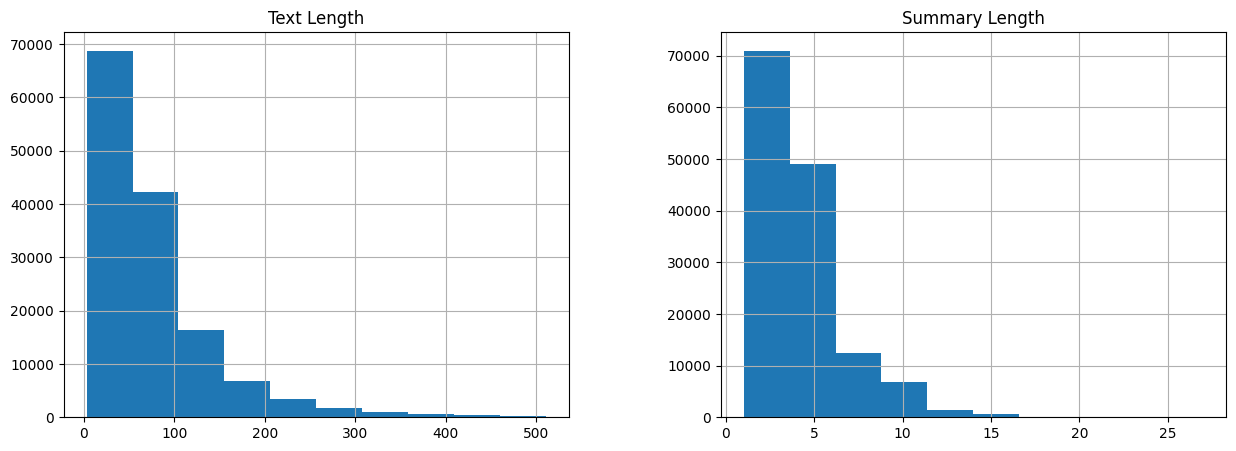

In [13]:
# Filter out rows with missing values
test_df = test_df.dropna(subset=['Text', 'Summary'])

# Calculate the lengths of the 'Text' and 'Summary' columns
Text_lent = [len(str(x).split()) for x in test_df['Text']]
Summary_lent = [len(str(x).split()) for x in test_df['Summary']]

datat = pd.DataFrame([Text_lent, Summary_lent]).T
datat.columns = ['Text Length', 'Summary Length']
datat.hist(figsize=(15,5))

In [14]:
# Save train data
train_df[['Text', 'Summary']].to_csv('/kaggle/working/train_data.txt', index=False, header=None, sep='\t')

# Save test data
test_df[['Text', 'Summary']].to_csv('/kaggle/working/test_data.txt', index=False, header=None, sep='\t')

In [11]:
import torch 

class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, file_path, tokenizer):
        self.texts = []
        self.summaries = []
        with open(file_path, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    text, summary = parts
                    self.texts.append(text)
                    self.summaries.append(summary)
                else:
                    # Handle cases where there is no tab separator
                    self.texts.append(line.strip())
                    self.summaries.append("")

        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        summary = str(self.summaries[idx])

        encoding = self.tokenizer(
            text,
            padding='max_length',
            max_length=1024,
            truncation=True,
            return_tensors='pt',
            pad_token_id=self.tokenizer.pad_token_id  # Add this line
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        labels = self.tokenizer(
            summary,
            padding='max_length',
            max_length=64,
            truncation=True,
            return_tensors='pt',
            pad_token_id=self.tokenizer.pad_token_id  # Add this line
        )['input_ids'].to(device)

        return input_ids, attention_mask, labels

In [12]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments

In [13]:

def load_dataset(file_path, tokenizer, block_size = 128):
    dataset = TextDataset(
        tokenizer = tokenizer,
        file_path = file_path,
        block_size = block_size,
    )
    return dataset

In [14]:
def load_data_collator(tokenizer, mlm = False):
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, 
        mlm=mlm,
    )
    return data_collator

In [15]:
def train(train_file_path, model_name, output_dir, overwrite_output_dir, per_device_train_batch_size, num_train_epochs, save_steps):
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    train_dataset = load_dataset(train_file_path, tokenizer)
    data_collator = load_data_collator(tokenizer)

    tokenizer.save_pretrained(output_dir)

    model = GPT2LMHeadModel.from_pretrained(model_name)
    model.to("cuda")  # Move model to GPU

    model.save_pretrained(output_dir)

    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=overwrite_output_dir,
        per_device_train_batch_size=per_device_train_batch_size,
        num_train_epochs=num_train_epochs,
        save_steps = save_steps,
        logging_steps = 100,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
    )

    trainer.train()
    trainer.save_model()

In [16]:
#train_file_path = "/content/drive/MyDrive/ColabNotebooks/data/chatbot_docs/combined_text/full_text/train.txt"
train_file_path = "/kaggle/working/train_data.txt"
model_name = 'gpt2'
#output_dir = '/content/drive/MyDrive/ColabNotebooks/models/chat_models/custom_full_text'
output_dir = '/kaggle/working/custommodel'
overwrite_output_dir = False
per_device_train_batch_size = 8
num_train_epochs = 3
save_steps = 50000

In [ ]:
# Train
train(
    train_file_path=train_file_path,
    model_name=model_name,
    output_dir=output_dir,
    overwrite_output_dir=overwrite_output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    num_train_epochs=num_train_epochs,
    save_steps=save_steps,
    
)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
100,3.745700
200,3.580700
300,3.568100
400,3.528900
500,3.486900
600,3.504100
700,3.489000
800,3.436400
900,3.444800
1000,3.444700


In [1]:
print("Model is training")

Model is training


In [2]:
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel, GPT2TokenizerFast, GPT2Tokenizer


In [5]:
!pip install rouge-score

In [6]:
from rouge import Rouge
from transformers import GPT2Tokenizer

def generate_text(model_path, sequence, max_length):
    model = load_model(model_path)
    tokenizer = load_tokenizer(model_path)
    ids = tokenizer.encode(f'{sequence}', return_tensors='pt')
    final_outputs = model.generate(
        ids,
        do_sample=True,
        max_length=max_length,
        pad_token_id=model.config.eos_token_id,
        top_k=50,
        top_p=0.95,
    )
    generated_text = tokenizer.decode(final_outputs[0], skip_special_tokens=True)
    return generated_text

# Load the pre-trained model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model_path = '/kaggle/working/custommodel'

# Initialize the ROUGE scorer
rouge = Rouge()

# Load the test dataset
test_dataset = ReviewDataset('test.txt', tokenizer)

# Evaluation and ROUGE score calculation
rouge_scores = []

for text, summary in zip(test_dataset.texts, test_dataset.summaries):
    generated_summary = generate_text(model_path, text, max_length=64)
    score = rouge.get_scores(generated_summary, summary)
    rouge_scores.append(score)
    print(f"Actual Summary: {summary}")
    print(f"Generated Summary: {generated_summary}")
    print(score)

# Print the average ROUGE scores
avg_rouge_scores = {
    'rouge-1': {'f': sum(score['rouge-1']['f'] for score in rouge_scores) / len(rouge_scores)},
    'rouge-2': {'f': sum(score['rouge-2']['f'] for score in rouge_scores) / len(rouge_scores)},
    'rouge-l': {'f': sum(score['rouge-l']['f'] for score in rouge_scores) / len(rouge_scores)}
}
print("\nAverage ROUGE Scores:")
print(avg_rouge_scores)

ModuleNotFoundError: No module named 'rouge'

In [3]:
def load_model(model_path):
    model = GPT2LMHeadModel.from_pretrained(model_path)
    return model


def load_tokenizer(tokenizer_path):
    tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_path)
    return tokenizer

def generate_text(model_path, sequence, max_length):
    
    model = load_model(model_path)
    tokenizer = load_tokenizer(model_path)
    ids = tokenizer.encode(f'{sequence}', return_tensors='pt')
    final_outputs = model.generate(
        ids,
        do_sample=True,
        max_length=max_length,
        pad_token_id=model.config.eos_token_id,
        top_k=50,
        top_p=0.95,
    )
    print(tokenizer.decode(final_outputs[0], skip_special_tokens=True))
    

In [4]:
model1_path = "/kaggle/working/custommodel"
sequence1 = "What is this"
max_len = 50
generate_text(model1_path, sequence1, max_len) 

What is this?! And what does that mean?

As we have already witnessed in the "Vampire in the Mirror" series and in the recent series about vampires, the question must now be asked, "what's going on with vampires?"


In [4]:
from rouge_score import rouge_scorer
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

def generate_text(model_path, sequence, max_length):
    
    model = load_model(model_path)
    tokenizer = load_tokenizer(model_path)
    ids = tokenizer.encode(f'{sequence}', return_tensors='pt')
    final_outputs = model.generate(
        ids,
        do_sample=True,
        max_length=max_length,
        pad_token_id=model.config.eos_token_id,
        top_k=50,
        top_p=0.95,
        max_new_tokens=max_length
    )
    return tokenizer.decode(final_outputs[0], skip_special_tokens=True)

def evaluate(test_file_path, model_path):
    tokenizer = GPT2Tokenizer.from_pretrained(model_path)
    model = GPT2LMHeadModel.from_pretrained(model_path)
    model.to("cuda")  # Move model to GPU

    # Load test dataset
    test_dataset = ReviewDataset(test_file_path, tokenizer)

    rouge_scorer_instance = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    rouge_scores = []

    for text, summary in zip(test_dataset.texts, test_dataset.summaries):
        generated_summary = generate_text(model_path,text, max_length=64)
        score = rouge_scorer_instance.score(summary, generated_summary)
        rouge_scores.append(score)

        print(f"Actual Text: {text}")
        print(f"Given Summary: {summary}")
        print(f"Generated Summary: {generated_summary}")
        print(f"ROUGE-1: Precision: {score['rouge1'].precision:.2f}, Recall: {score['rouge1'].recall:.2f}, F1-Score: {score['rouge1'].fmeasure:.2f}")
        print(f"ROUGE-2: Precision: {score['rouge2'].precision:.2f}, Recall: {score['rouge2'].recall:.2f}, F1-Score: {score['rouge2'].fmeasure:.2f}")
        print(f"ROUGE-L: Precision: {score['rougeL'].precision:.2f}, Recall: {score['rougeL'].recall:.2f}, F1-Score: {score['rougeL'].fmeasure:.2f}")
        print()

    return rouge_scores

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=33d9ec2b09a51fa68474db8ea4db53cd2016ac8288bd390db28485423edcda82
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [7]:
evaluate('/kaggle/working/test_data.txt','/kaggle/working/custommodel')

NameError: name 'tokenizer' is not defined